### Checking for GPU availability

In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Runing on: {}'.format(device))

Runing on: cpu


### Testing our U-Net based model implementation

X     --> torch.Size([1, 1, 256, 448])
y     --> torch.Size([1, 256, 448])
y_hat --> torch.Size([1, 256, 448])


Text(0.5, 1.0, 'Output mask')

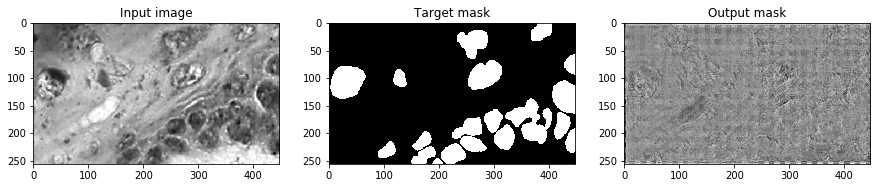

In [2]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

from unet_model import *
from image_utils import *
from oral_mice_tissues_dataset import *
from torch.autograd import Variable

torch.cuda.empty_cache()

# load the input image (X) in RGB color model and its corresponding mask (Y)
dysplasia_level = "1-healthy"
color_normalization = "1-original"
X = load_pil_image("../histological_oral_mice_tissues/roi/image/train/{}/{}/image003-2-roi1.tif".format(color_normalization, dysplasia_level), False, "RGB")
y = load_pil_image("../histological_oral_mice_tissues/roi/mask/{}/image003-2-roi1.tif".format(dysplasia_level))

X, y = data_augmentation(input_image=X, output_mask=y, aug=False)
X = X[2] # 'b' channel from rgb
X = Variable(X.unsqueeze(0).unsqueeze(0).to(device)) #X = Variable(X.unsqueeze(0).to(device))
y = Variable(y.unsqueeze(0).to(device))
print('X     --> {}'.format(X.size()))
print('y     --> {}'.format(y.size()))


# load our u-net based model
with torch.no_grad():
    model = UNet(in_channels=1, out_channels=1, padding=True).to(device)

criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters())
optimizer.zero_grad()       

# runs our u-net based model for the input image (X) and predicts the y_hat output mask
y_hat = model(X).squeeze(0)
print('y_hat --> {}'.format(y_hat.size()))

# test the weight update step
loss = criterion(y_hat, y)
loss.backward()
optimizer.step()


# Show the output images
X_numpy = X.cpu().numpy()
y_numpy = y.cpu().numpy()
y_hat_numpy = y_hat.detach().cpu().numpy()

f, ax = plt.subplots(1, 3, figsize=(15, 15))
ax[0].imshow(X[0][0].cpu(), cmap="gray")
ax[0].set_title('Input image')

ax[1].imshow(y_numpy[0], cmap='gray')
ax[1].set_title('Target mask')

ax[2].imshow(y_hat_numpy[0], cmap='gray')
ax[2].set_title('Output mask')

### Training our U-Net based model implementation

In [ ]:
from unet_model import *
from oral_mice_tissues_dataset import *

import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable


# create the datasets
batch_size = 1
color_normalization = "1-original"
dataset_dir = "../histological_oral_mice_tissues/roi"
color_model = "RGB"
dataloaders = create_dataloader(color_normalization, batch_size, dataset_dir, color_model)


# Checking for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Runing on: {}'.format(device))


# load our u-net based model
torch.cuda.empty_cache()
model = UNet(in_channels=1, out_channels=1, padding=True).to(device)
#model = load_checkpoint(file_path="UNet_IN-3_OUT-1_UPMODE-ConvTranspose__Dataset-1-original__Epoch-263__Size-448x256_RGB_b.pt")
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(model.parameters())


# train the model
since = time.time()
n_epochs = 500
start_epoch = 1
model.train()
for epoch in range(start_epoch, n_epochs+1):

    if (epoch == start_epoch or epoch == n_epochs or epoch%50 == 0 ):
        print("")
        time_elapsed = time.time() - since
        print('Epoch {}/{} ({:.0f}m {:.0f}s)'.format(epoch, n_epochs, time_elapsed // 60, time_elapsed % 60))
        print('-' * 20)
    for batch_idx, (data, target, fname, original_size) in enumerate(dataloaders['train']):
        
        # N x C x H x W
        data = Variable(data.to(device))[:, 2, :, :].unsqueeze(1) # 'b' channel from rgb
        target = Variable(target.to(device))
        #print('X     --> {}'.format(data.size()))
        #print('y     --> {}'.format(target.size()))
                
        optimizer.zero_grad()
        #output = model(data)
        output = model(data).squeeze(0)
        #print('y_hat --> {}'.format(output.size()))
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if (epoch == start_epoch or epoch == n_epochs or epoch%50 == 0 ) and ((batch_idx+1)%20 == 0):
            print('\tBatch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                (batch_idx+1), 
                (batch_idx+1) * len(data), 
                len(dataloaders['train'].dataset),
                100. *(((batch_idx+1) * len(data)) / len(dataloaders['train'].dataset)), 
                loss.item()))
        if loss.item() < 0.001 or math.isnan(loss.item()):
            break
            
    #print("\tLoss: {:.6f}".format(loss.item()))
    if loss.item() < 0.001 or math.isnan(loss.item()):
        break
        
time_elapsed = time.time() - since
print('-' * 20)
print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))


# Save the trained model
torch.save({
            'epoch': epoch,
            'batch_size': batch_size,
            'dataset': 'OralMiceTissuesDataset_{}'.format(color_normalization),
            'model_in_channels': model.model_input_channels(),
            'model_out_channels': model.model_output_channels(),
            'model_up_mode': model.model_up_mode(),
            'model_padding': model.model_padding(),
            'criterion': 'nn.BCELoss',
            'optimizer': 'optim.Adam',
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, "{}__Dataset-{}__Epoch-{}__Size-448x256_RGB_b.pt".format(model.name(), color_normalization, epoch))

In [ ]:
torch.save({
            'epoch': epoch,
            'batch_size': batch_size,
            'dataset': 'OralMiceTissuesDataset_{}'.format(color_normalization),
            'model_in_channels': model.model_input_channels(),
            'model_out_channels': model.model_output_channels(),
            'model_up_mode': model.model_up_mode(),
            'model_padding': model.model_padding(),
            'criterion': 'nn.BCELoss',
            'optimizer': 'optim.Adam',
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, "{}__Dataset-{}__Epoch-{}__Size-448x256_RGB_b.pt".format(model.name(), color_normalization, epoch))

### Runs our trained U-Net based model on test dataset

In [ ]:
from unet_model import *
from oral_mice_tissues_dataset import *


from torchvision import transforms
from torchvision import utils
from torch.autograd import Variable

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


# create the datasets
batch_size = 1
color_normalization = "1-original"
dataset_dir = "../histological_oral_mice_tissues/roi"
color_model = "RGB"
dataloaders = create_dataloader(color_normalization, batch_size, dataset_dir, color_model)


# Checking for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print()
print('Runing on: {}'.format(device))


# iterate over test dataset images            
t1 = datetime.now()  
for batch_idx, (images, masks, fname, original_size) in enumerate(dataloaders['test']):
    
    
    X = Variable(images.to(device))[:, 2, :, :].unsqueeze(1) # 'g' channel from rgb
    print('Batch {}: {}/{} images: {} masks: {} {}'.format(
        (batch_idx+1), 
        (batch_idx+1) * len(images), 
        len(dataloaders['test'].dataset),
        images.shape,
        masks.shape,
        datetime.now()))
    
    
    y_hat = model(X).squeeze(0)
    X_numpy = X.cpu().numpy()
    y_hat_numpy = y_hat.detach().cpu().numpy()
    
    
    f, ax = plt.subplots(1, 3, figsize=(20, 20))
    
    
    # show the input image
    input_image = images[0][2] # 'b' channel from rgb
    ax[0].imshow(input_image)
    ax[0].set_title('{} (input)'.format(fname[0]))
    
    # show the mask image
    mask_image = masks[0]
    ax[1].imshow(mask_image, cmap='gray')
    ax[1].set_title('{} (mask)'.format(fname[0]))
    
    # show the predicted output image
    output_image = y_hat[0].squeeze(0).detach().cpu().numpy()
    output_image_otsu  = otsu_threshold(np_img=output_image)
    output_image_hyst  = hysteresis_threshold(np_img=output_image, low=0.2, high=0.8)
    output_image_basic = basic_threshold(np_img=output_image, threshold=0.2)
    
    ax[2].imshow(output_image_otsu, cmap='gray')
    ax[2].set_title('{} (output)'.format(fname[0]))
        